In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
from transformation import *
# #make a graph of the training history to see how the loss changes over time
import matplotlib.pyplot as plt

In [2]:

# Chargement des données depuis le fichier CSV
def load_data(csv_path):
    df = pd.read_csv(csv_path)
    # Exemple: Charger les chemins des images et les valeurs de transformation
    image_paths = df['image_path'].tolist()
    #transformations = df[['brightness', 'saturation', 'contrast', 'sharpness']].values
    transformations = df[['brightness', 'saturation', 'contrast', 'sharpness', 'temperature']].values
    return image_paths, transformations

# Chargement et prétraitement des images
def load_and_preprocess_images(image_paths, target_size=(256, 256)):
    images = []
    for path in image_paths:
        image = tf.keras.preprocessing.image.load_img(path, target_size=target_size)
        image = tf.keras.preprocessing.image.img_to_array(image)
        image = image / 255.0  # Normalisation des valeurs de pixels
        images.append(image)
    return np.array(images)

# Création du modèle CNN simple
def create_model(input_shape):
    model = Sequential([
        Conv2D(64, (3, 3), activation='relu', input_shape=input_shape),
        MaxPooling2D((2, 2)),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(64, activation='relu'),
        Dense(5)  # 4 sorties pour les valeurs de transformation
    ])
    model.compile(optimizer='adam', loss='mse')  # Utilisez 'mse' pour les problèmes de régression
    return model

In [3]:
from sklearn.model_selection import train_test_split

In [4]:
csv_validation_path = 'dataset/transformations.csv'
csv_path = 'dataset_anime/transformations.csv'
image_paths, transformations = load_data(csv_path)
validation_image_paths, validation_transformations = load_data(csv_validation_path)

images = load_and_preprocess_images(image_paths)
images_validation = load_and_preprocess_images(validation_image_paths)

# X_train, X_val, y_train, y_val = train_test_split(images, transformations, test_size=0.2, random_state=42)
X_train, y_train = images, transformations
X_val, y_val = images_validation, validation_transformations

input_shape = images[0].shape

In [5]:
model = create_model(input_shape)

C:\Users\Trang\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [14]:
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=4, batch_size=32)

Epoch 1/4
93/93 ━━━━━━━━━━━━━━━━━━━━ 82s 879ms/step - loss: 0.0685 - val_loss: 0.1236
Epoch 2/4
93/93 ━━━━━━━━━━━━━━━━━━━━ 88s 944ms/step - loss: 0.0649 - val_loss: 0.1483
Epoch 3/4
93/93 ━━━━━━━━━━━━━━━━━━━━ 86s 924ms/step - loss: 0.0649 - val_loss: 0.1427
Epoch 4/4
93/93 ━━━━━━━━━━━━━━━━━━━━ 82s 880ms/step - loss: 0.0599 - val_loss: 0.1267


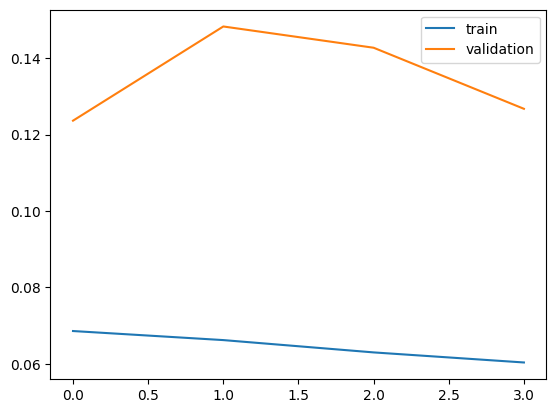

In [15]:

plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.legend()
plt.show()


In [16]:
# from tensorflow.keras.models import load_model
# from tensorflow.keras.losses import MeanSquaredError
# from tensorflow.keras.metrics import MeanSquaredError as MSE

# model = load_model('model_v2.h5', custom_objects={'mse': MSE, 'MeanSquaredError': MeanSquaredError})


In [17]:
#take random image in dataset folder
image = 'dataset_validation/transformed_frame_50.jpg'


predictions = model.predict(load_and_preprocess_images([image]))
print(predictions)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
[[0.7977979  1.0622575  0.82126045 0.7524634  1.0926775 ]]


In [18]:
import os
import pandas as pd
from PIL import Image, ImageEnhance
import random
import csv

[0.7977979183197021, 1.0622575283050537, 0.8212604522705078, 0.7524634003639221, 1.0926774740219116]


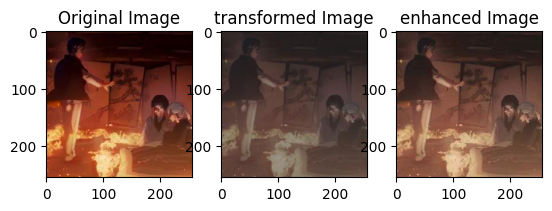

In [20]:
#show the original image and the transformed image
enhanced_image = apply_reverse_transformations(image, predictions[0])
#remove "transformed_"
original_image = image.replace("transformed_", "")
original_image = original_image.replace("dataset", "raw")

transformed_image = Image.open(image)

#~show both images
fig, ax = plt.subplots(1, 3)
ax[1].imshow(transformed_image)
ax[1].set_title('transformed Image')
ax[0].imshow(Image.open(original_image))
ax[0].set_title('Original Image')
ax[2].imshow(enhanced_image)
ax[2].set_title('enhanced Image')
plt.show()

In [21]:
model.save('model_v2.h5')